In [1]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

In [2]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/imagenet_labels.txt"):
	urlretrieve(
		url="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt",
		filename="attention_data/imagenet_labels.txt",
	)
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
	urlretrieve(
		url="https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz",
		filename="attention_data/ViT-B_16-224.npz",
	)
imagenet_labels = dict(enumerate(open('attention_data/imagenet_labels.txt')))

In [3]:
imagenet_labels

{0: 'tench, Tinca_tinca\n',
 1: 'goldfish, Carassius_auratus\n',
 2: 'great_white_shark, white_shark, man-eater, man-eating_shark, Carcharodon_carcharias\n',
 3: 'tiger_shark, Galeocerdo_cuvieri\n',
 4: 'hammerhead, hammerhead_shark\n',
 5: 'electric_ray, crampfish, numbfish, torpedo\n',
 6: 'stingray\n',
 7: 'cock\n',
 8: 'hen\n',
 9: 'ostrich, Struthio_camelus\n',
 10: 'brambling, Fringilla_montifringilla\n',
 11: 'goldfinch, Carduelis_carduelis\n',
 12: 'house_finch, linnet, Carpodacus_mexicanus\n',
 13: 'junco, snowbird\n',
 14: 'indigo_bunting, indigo_finch, indigo_bird, Passerina_cyanea\n',
 15: 'robin, American_robin, Turdus_migratorius\n',
 16: 'bulbul\n',
 17: 'jay\n',
 18: 'magpie\n',
 19: 'chickadee\n',
 20: 'water_ouzel, dipper\n',
 21: 'kite\n',
 22: 'bald_eagle, American_eagle, Haliaeetus_leucocephalus\n',
 23: 'vulture\n',
 24: 'great_grey_owl, great_gray_owl, Strix_nebulosa\n',
 25: 'European_fire_salamander, Salamandra_salamandra\n',
 26: 'common_newt, Triturus_vulgari

In [4]:
# Test Image
# img_url = "https://as1.ftcdn.net/v2/jpg/01/63/53/20/1000_F_163532024_yuon7OJQYn8gnzTQpjXKKtO69XhF9SWx.jpg"
# img_url = "https://as2.ftcdn.net/v2/jpg/01/67/24/45/1000_F_167244514_0AcAa9opIWbbuNi4jxgmT7nw6fkPTFqJ.jpg"
# img_url = "https://as1.ftcdn.net/v2/jpg/02/94/68/58/1000_F_294685879_tFywW5pdkCVdQM11ALrxClXJqibJimSS.jpg"
# img_url = "https://www.finna.fi/Cover/Show?source=Solr&id=sa-kuva.sa-kuva-63836"
# img_url = "https://www.finna.fi/Cover/Show?source=Solr&id=sa-kuva.sa-kuva-23125"
# img_url = "https://www.finna.fi/Cover/Show?source=Solr&id=sa-kuva.sa-kuva-105292"
img_url = "https://www.finna.fi/Cover/Show?source=Solr&id=sa-kuva.sa-kuva-89881"
urlretrieve(url=img_url, filename="attention_data/img.jpg")

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose(
  [
		transforms.Resize((224, 224)),
		transforms.ToTensor(),
		transforms.Normalize(
			mean=[0.5, 0.5, 0.5], 
			std=[0.5, 0.5, 0.5]
		),
	]
)
im = Image.open("attention_data/img.jpg")
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [5]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
		joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
		
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

torch.Size([1, 1000]) torch.Size([1, 1000])
Prediction Label and Attention Map!

0.31127 : snowplow, snowplough
0.18152 : tractor
0.07007 : half_track
0.06100 : plow, plough
0.06069 : cannon


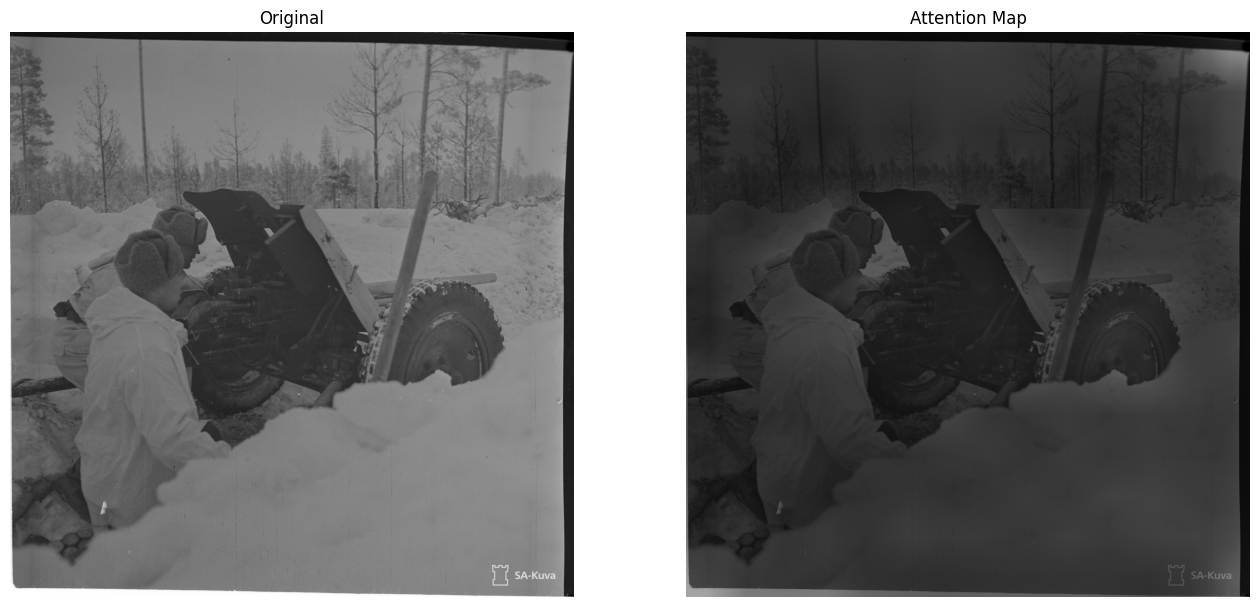

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 14))

ax1.set_title('Original')
ax1.axis('off')
ax2.set_title('Attention Map')
ax2.axis('off')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
topK = torch.argsort(probs, dim=-1, descending=True)
print(probs.shape, topK.shape)
print("Prediction Label and Attention Map!\n")
for idx in topK[0, :5]:
	print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

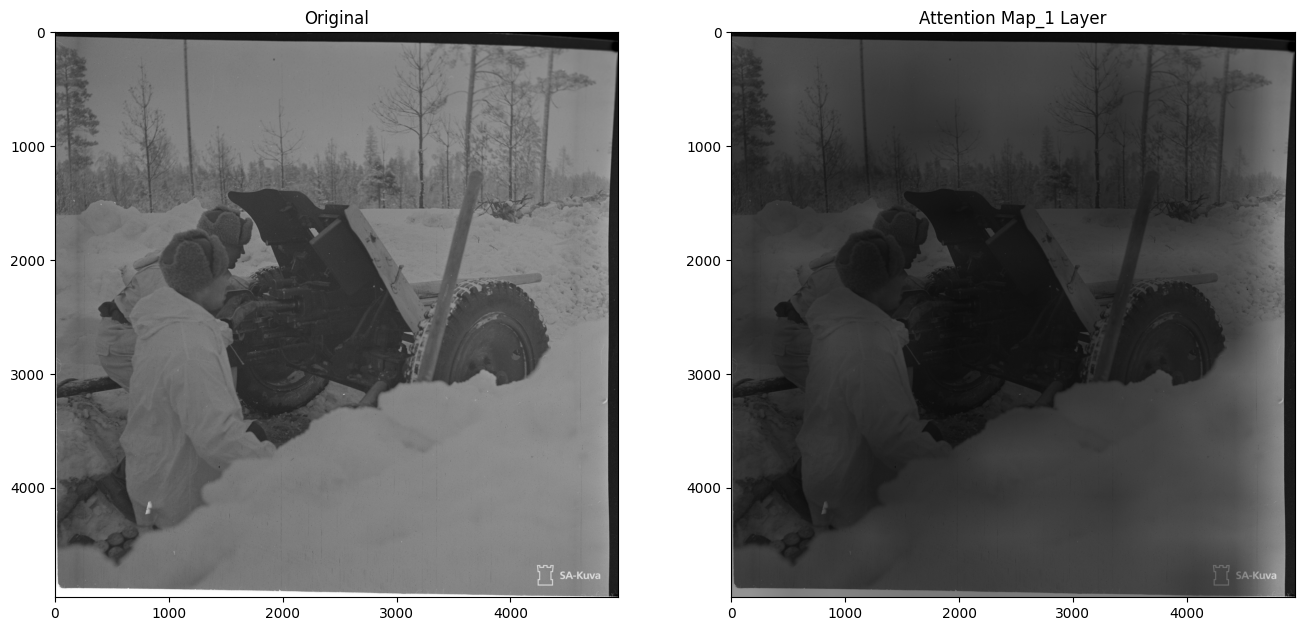

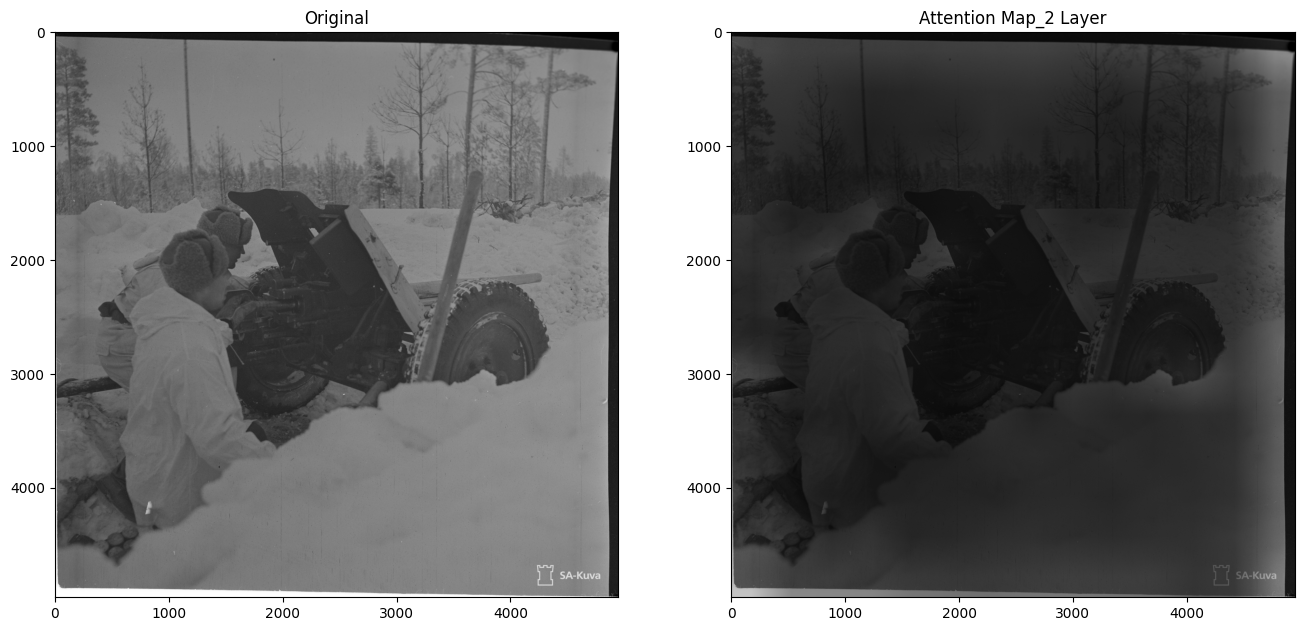

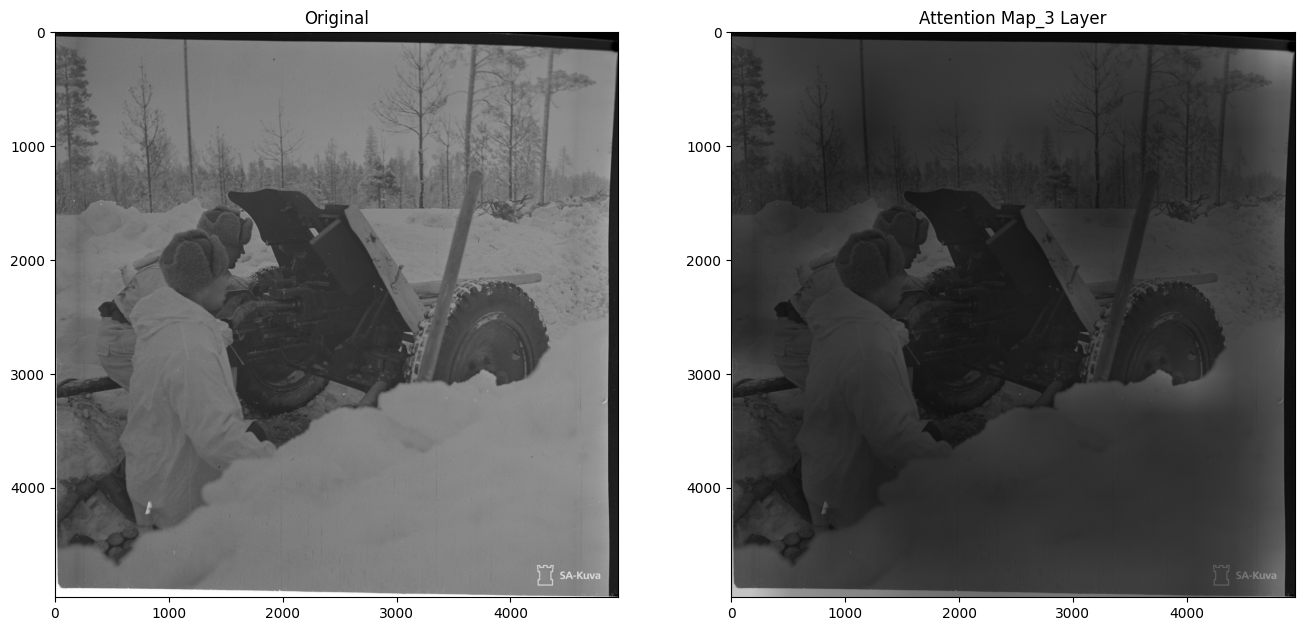

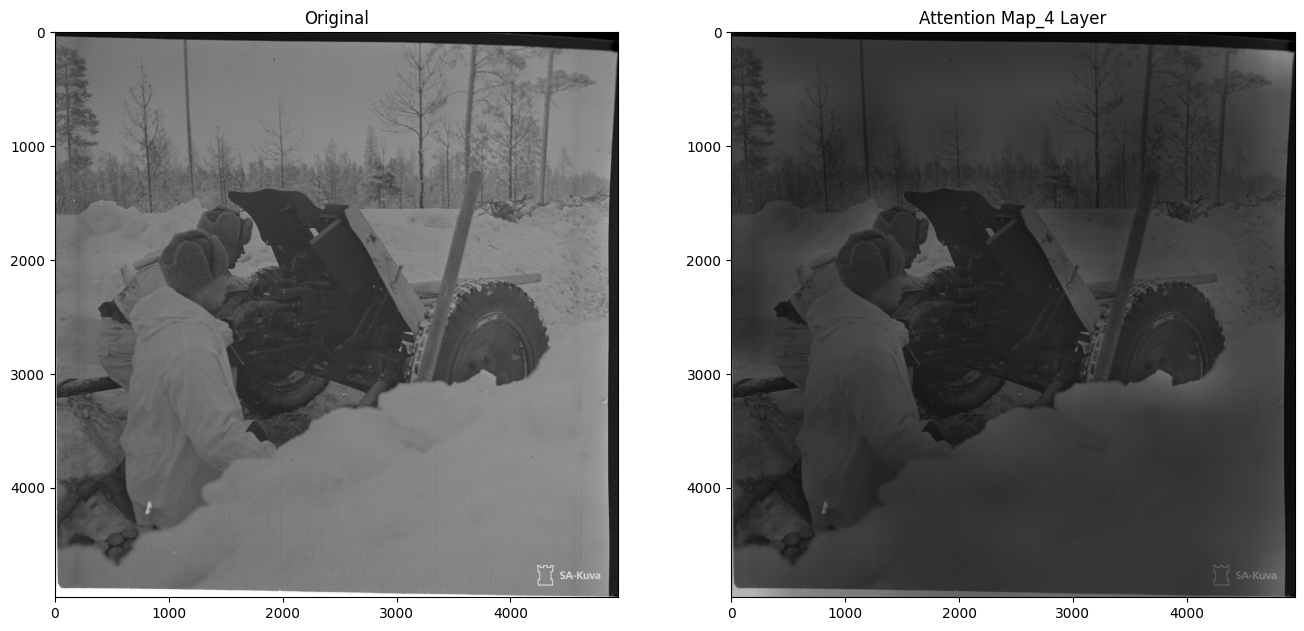

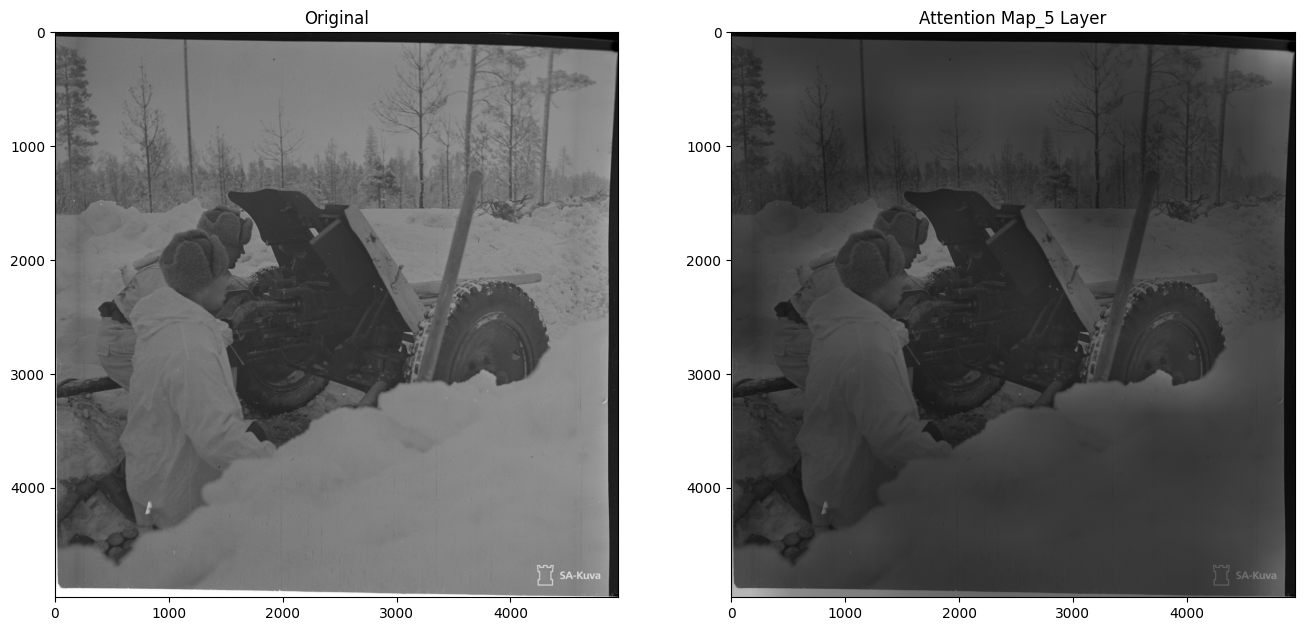

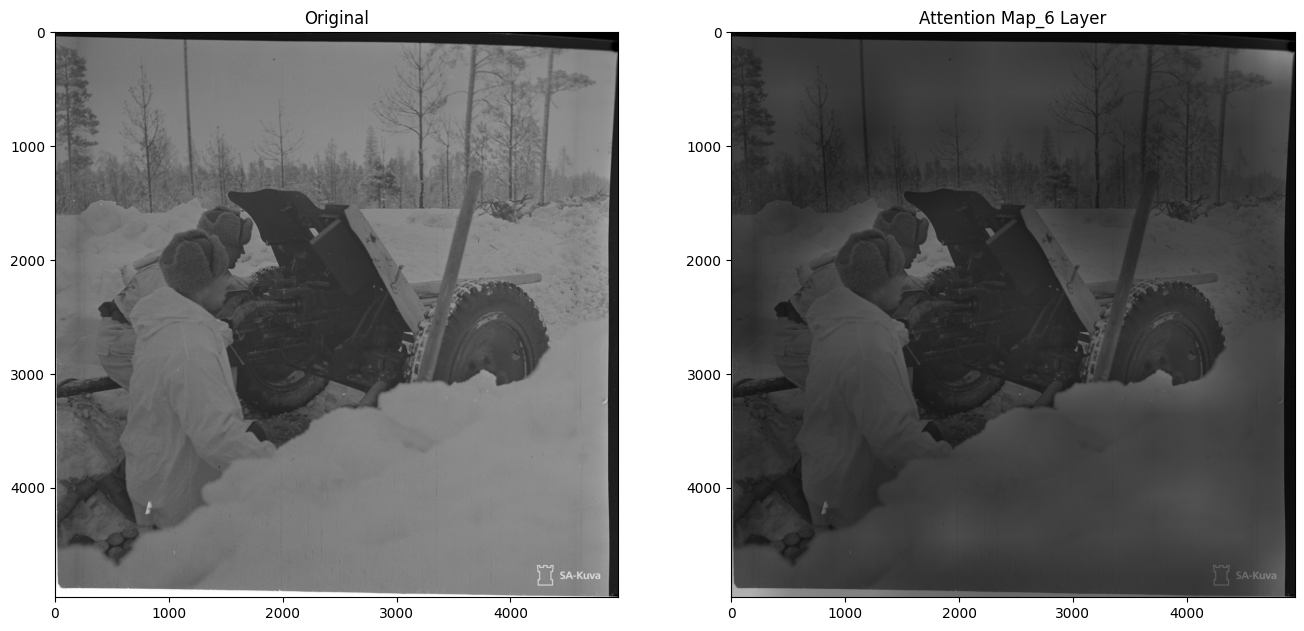

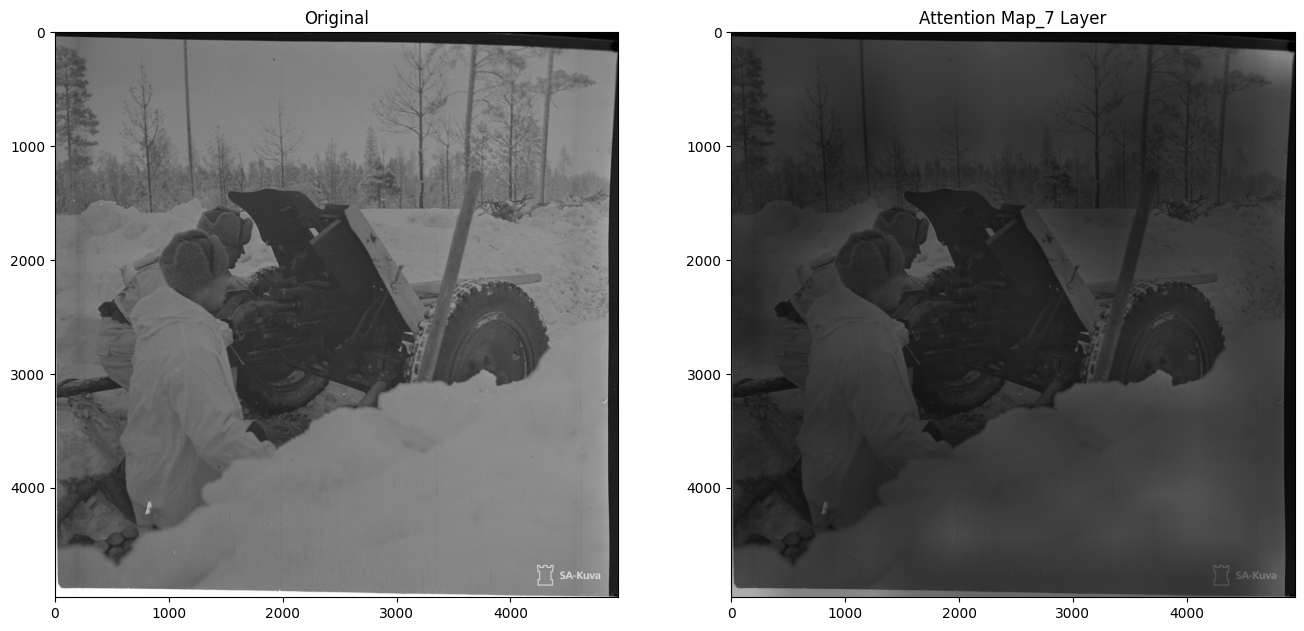

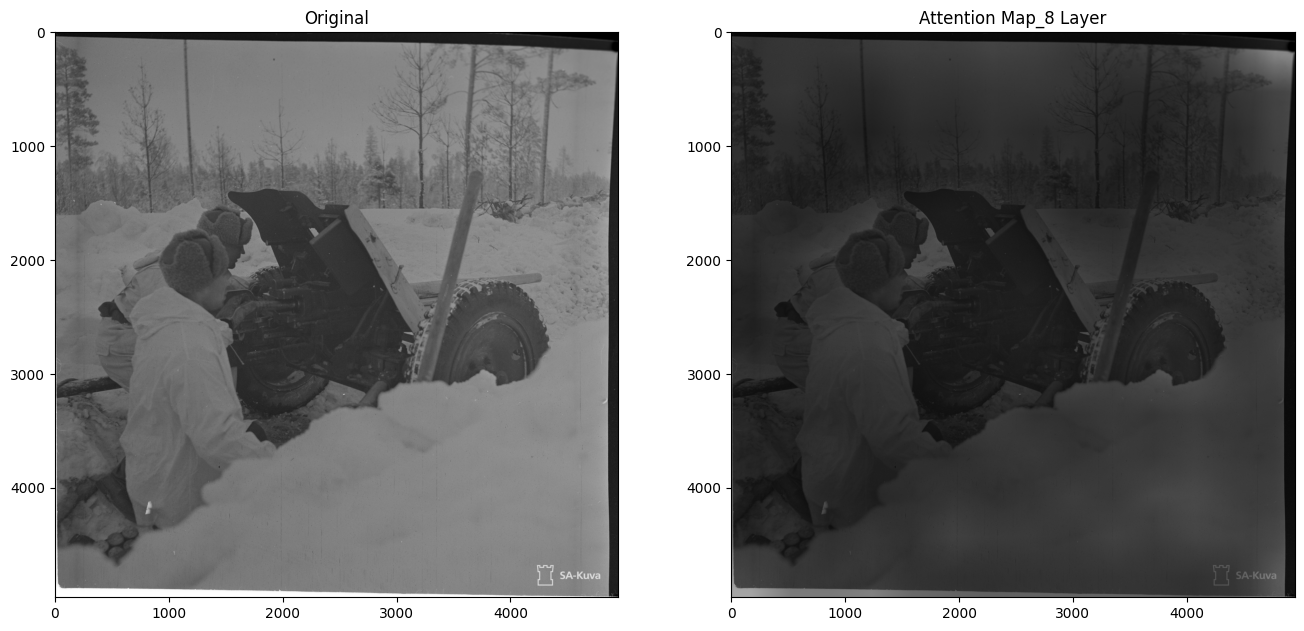

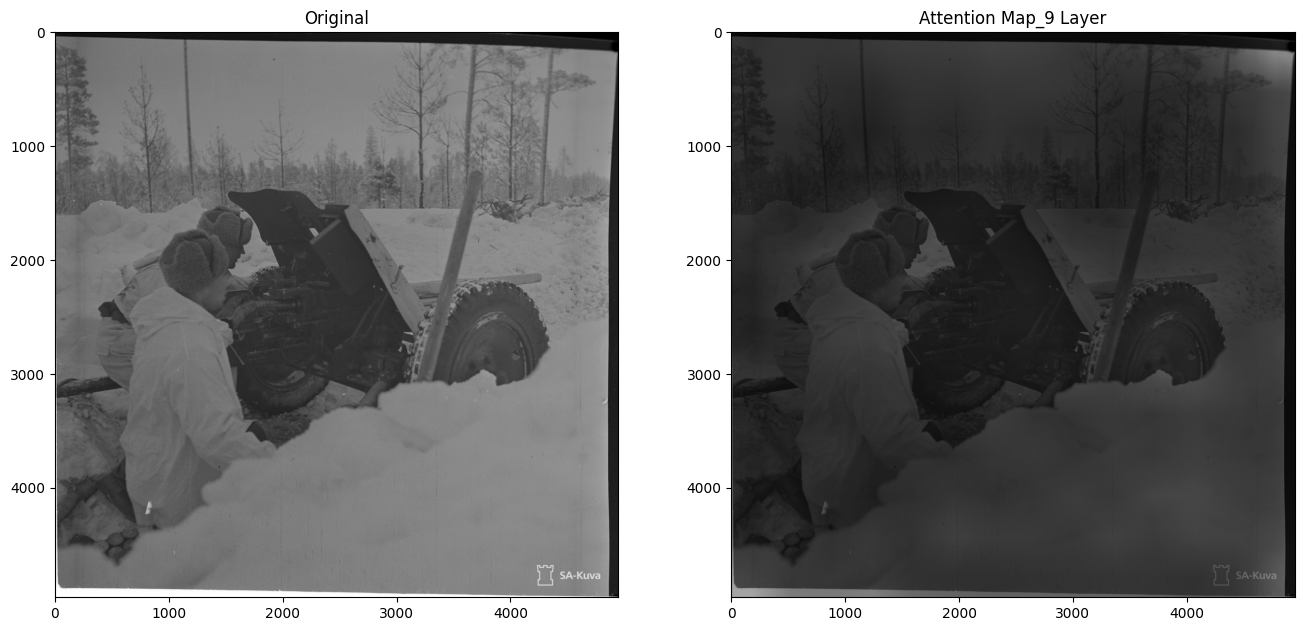

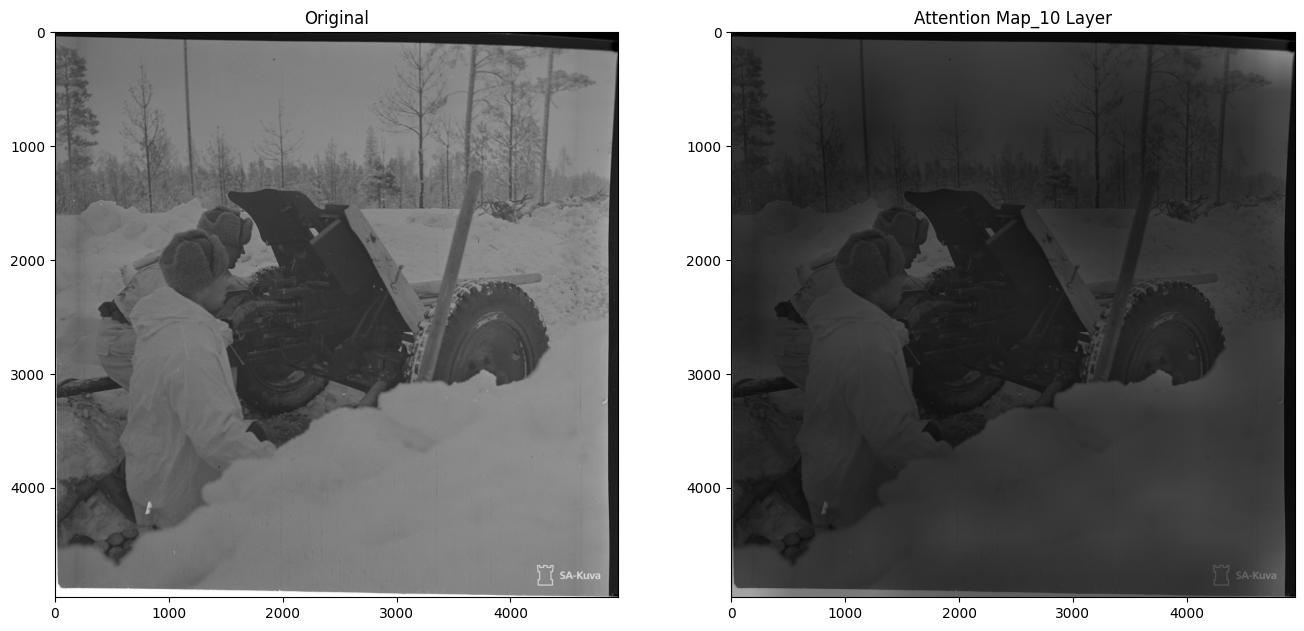

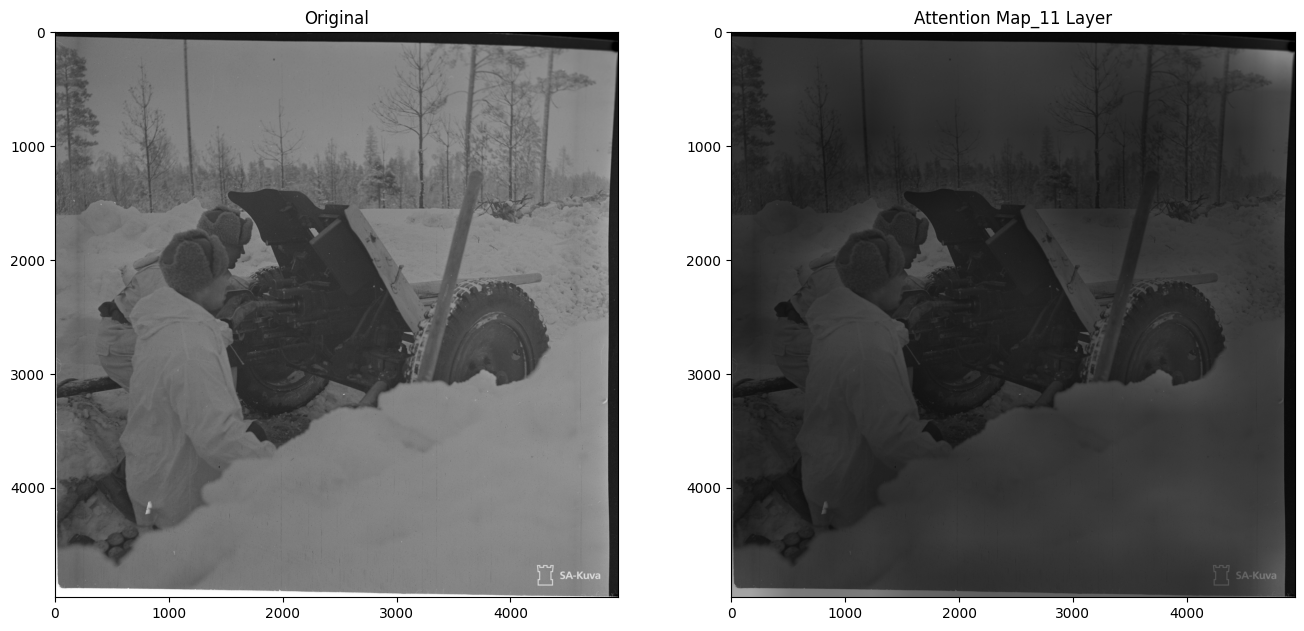

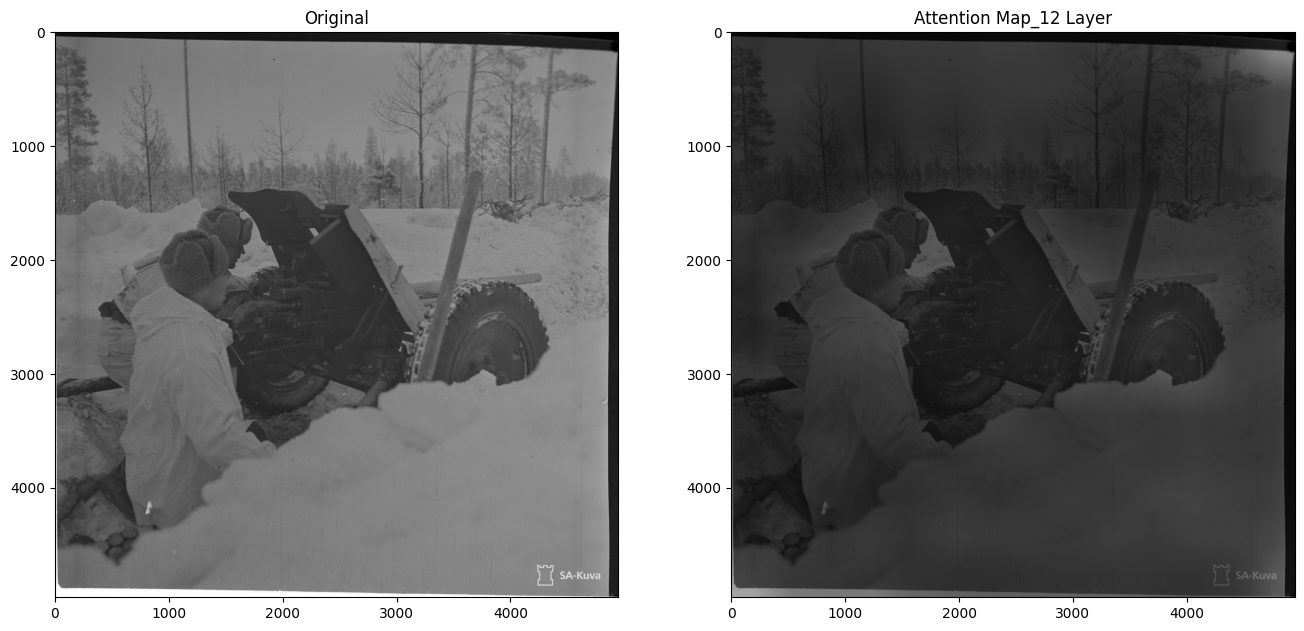

In [7]:
for i, v in enumerate(joint_attentions):
		# Attention from the output token to the input space.
		mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
		mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
		result = (mask * im).astype("uint8")

		fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
		ax1.set_title('Original')
		ax2.set_title('Attention Map_%d Layer' % (i+1))
		_ = ax1.imshow(im)
		_ = ax2.imshow(result)